# Lab 2
## Louis Gauthy (i6188059) & Louis Meeckers (i6258699)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
from PIL import Image
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model

ssl._create_default_https_context = ssl._create_unverified_context

# Load the data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Concatenate
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# 80% train, 10% validation, 10% test
x_train, x_test, _, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, _, _ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Print shape
print (x_train.shape) # 80% => 48 000 instances
print (x_val.shape) # 10% => 6 000 instances
print (x_test.shape) # 10% => 6 000 instances

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


## Normalize the data
We divide the value of each pixel by 255 so that the value is in the interval 0,1.

In [4]:
print("max pixel values = ",np.max(x_train))
print("max pixel values = ",np.min(x_train))

max pixel values =  1.0
max pixel values =  0.0


# Reconstruction

## Create autoencoder

In [5]:
class Autoencoder(Model):

  def __init__(self, latent_dim = 16, strides=1, padding='same', input_dim = 3, output_dim = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=3, strides=strides, padding=padding, activation='relu', input_shape=(32,32,input_dim)),
      layers.MaxPooling2D(pool_size=(2, 2), padding=padding),
      layers.Conv2D(12, kernel_size=3, strides=strides, padding=padding, activation='relu'),
      layers.MaxPooling2D(pool_size=(2, 2), padding=padding),
      layers.Conv2D(latent_dim, kernel_size=3, strides=strides, padding=padding, activation='relu')
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(12, kernel_size=3, strides=strides, padding=padding, activation='relu'),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(output_dim, kernel_size=3, strides=strides, padding=padding, activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


## Display structure NN

We use the "Mean Squared Error" for the loss function and for the metric, so mesure the performances of our NN and we use the adam optimizer.

In [6]:

autoencoder = Autoencoder()
# Define optimizer and the error function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")

## Fit the data (epochs=10)

In [7]:

inital_history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
1500/1500 [==============================] - 35s 22ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 2/10
1500/1500 [==============================] - 33s 22ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/10
1500/1500 [==============================] - 35s 24ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 4/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/10
1500/1500 [==============================] - 52s 35ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoc

## Summary
We can observe below that our neural network is composed of two layer. The first one corresponds to the encoder and the second one of the decoder. We can observe that their output shape corresponds to the ones specified above.

In [8]:
print(autoencoder.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 8, 8, 16)          2844      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         2067      
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________
None


### Summary of the encoder

In [14]:
print(autoencoder.get_layer(index=0).summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 12)        876       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          1744      
Total params: 2,844
Trainable params: 2,844
Non-trainable params: 0
_________________________________________________________________
None


### Summary of the decoder

In [15]:
print(autoencoder.get_layer(index=1).summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 12)        1740      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 12)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 3)         327       
Total params: 2,067
Trainable params: 2,067
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
def plot_training_curves(acc, val_acc, loss = None, val_loss = None, ft = False):
    
  plt.figure(figsize=(5, 5))
#   plt.subplot(2, 1, 1)
  plt.title("Train and validation MSE over the epochs")
  plt.plot(acc, label='Training MSE')
  plt.plot(val_acc, label='Validation MSE')
  plt.legend(loc='lower right')
  plt.ylabel('Error')
  plt.xlabel("epochs")
  plt.title('Training and Validation Error')

#   plt.subplot(2, 1, 2)
#   plt.plot(loss, label='Training Loss')
#   plt.plot(val_loss, label='Validation Loss')
#   plt.legend(loc='upper right')
#   plt.ylabel('Cross Entropy')
#   plt.title('Training and Validation Loss')
#   plt.xlabel('epoch')
  plt.show()

## The evolution of the Mean Squared Error with epochs

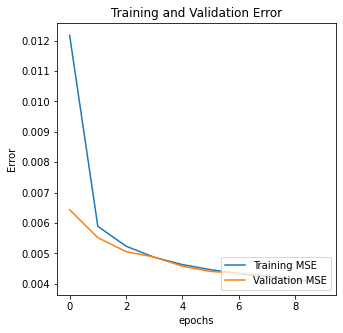

In [9]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

It is observed here that the error is dropping in the first epochs then gradualy stabilises towards $\approx$ 0.045

## Model Evaluation

In [10]:
metrics = autoencoder.evaluate(x_test,x_test)
mae = metrics[1]
print('Test Error :', mse)

188/188 [==============================] - 2s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Test Error : [0.012170931324362755, 0.0058909086510539055, 0.00523773580789566, 0.004872499033808708, 0.004631478805094957, 0.004464106168597937, 0.00433002132922411, 0.0042189499363303185, 0.004124506842344999, 0.004044022876769304]


We get a similar error the last epoch's validation error

## Display some results

In [40]:
def plot_test(autoencoder,x_test,gray = False):
 encoded_imgs = autoencoder.encoder(x_test).numpy()
 decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

 if gray:
  x_test = x_test.numpy()
  test_re = rgb_convertion(decoded_imgs,x_test)

 iStart = 10 # only change this value to display different value (must be >= 0)
 n = 10
 plt.figure(figsize=(20, 4))
 for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  if gray: plt.imshow((x_test[iStart + i].T[0][:][:]).T)
  else: plt.imshow(x_test[iStart + i])

  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  if gray:   plt.imshow(test_re[iStart + i])
  else :  plt.imshow(decoded_imgs[iStart + i])
  plt.title("reconstruction")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
 plt.show()

We can observe on the results below that the reconstructed version of the original images are pretty good even if the reconstructed image are slightly blurred. This is due to the fact that the lower representation of each image in the latent space is lower and therefore contain less information as the original image. However, we can observe that our CNN is managing to fit the data sufficiently properly to be able to recognize the reconstructed image immediatly with good precision. Therefore, we understand that the best way to compress image data by keeping the best representation of it is to take away details.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


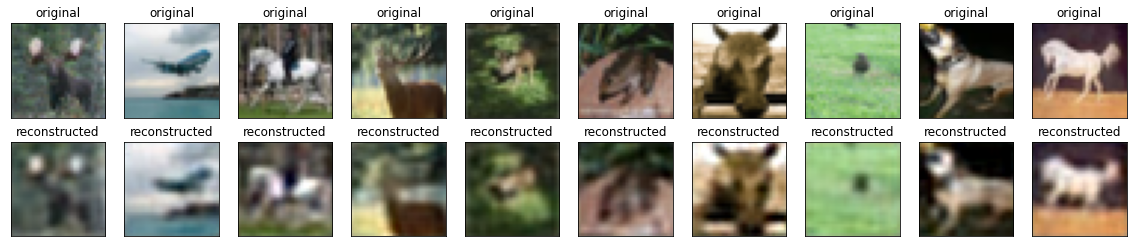

In [238]:
plot_test(autoencoder,x_test)

# Latent space

In [13]:
s = 1 #strides
c = 16 #channels
w = 32*3 #input volume
k = 3 #kernel size
p = (k-1)/2 #padding (forumla is for padding = same!)

def lspace_size(c,k,s,w,p = (k-1)/2):
   return c*np.power(1+ w-k+2*p/s,2)

print("latent space size = ",lspace_size(c,k,s,w))

latent space size =  147456.0


# Hyper parameter tuning
> e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) 
-> What is the impact of those in the reconstruction error after training? Is there an obvious correlation between the size of the latent space representation and the error?

In [17]:
def build_ae(latent_dim = 16, strides=1, padding='same', verbose = 0):
    autoencoder = Autoencoder(latent_dim, strides, padding)
   # Define optimizer and the error function
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
    history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                verbose=verbose,
                validation_data=(x_val, x_val))
    return history.history['val_mean_squared_error']

# error = build_ae(latent_dim = 32)
# print(error)



## Mean squared error according to stride

In [36]:
strides = [1, 2, 3, 4, 5, 6]
print(strides)

errors = []
for s in strides:
    error = build_ae(strides = s)
    errors.append(error[len(error)-1])
    print(s, error[len(error)-1])

[1, 2, 3, 4, 5, 6]
1 0.003984315786510706
2 0.11837777495384216
3 0.0445818267762661
4 0.13215595483779907
5 0.04484953358769417
6 0.044945474714040756


We can observe on the plot below, that the recommanded value of the assignment (= 1) is returning the lowest mean squared error (around 30 times lower than the error produced by higher strides value).

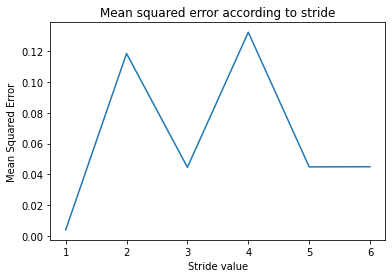

In [37]:
plt.title("Mean squared error according to stride")
plt.xlabel("Stride value")
plt.ylabel("Mean Squared Error")

plt.xticks(strides)

plt.plot(strides, errors)

plt.show()

## Mean squared error according to the number of dimensions in the last convolutional layer of the encoder 

In [ ]:
dims = [2, 4, 8, 16, 32, 64, 128, 256, 512, 640, 768, 896, 1024, 1280, 1536, 1792]
print(dims)

errors = []
for dim in dims:
    error = build_ae(latent_dim = dim)
    errors.append(error[len(error)-1])
    print(dim, error[len(error)-1])

The experiment above is building many autoencoders with different dimensions for the last convolutional layer of the encoder. Due to the fact that this experiment took hundreds of minutes and was realised in multiple times, we copied the results in the array bellow (called "errors") to not lose the results.
We decided to show on the plot only the first 12 results of the 12 first dimensions knowing that the improvement of the mean squared error was insignificant as we kept increasing. Moreover, we can observe on the plot below that once the latent dim 128 is reach, no real improvement are made in the following (higher) dimensions.

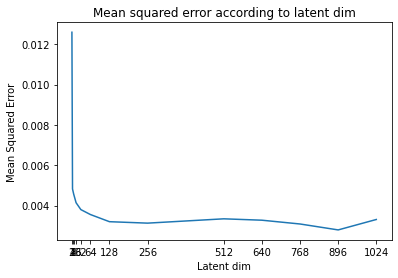

In [14]:
errors = [0.01259929034858942, 0.00482218200340867, 0.004560419358313084, 0.004137229174375534, 0.0037965828087180853, 0.0035522794350981712, 0.003196542151272297, 0.003124689683318138, 0.0033389939926564693, 0.0032702074386179447, 0.003082230454310775, 0.002788195386528969, 0.003305373713374138, 0.0031323025468736887, 0.0028343768790364265, 0.0029489551670849323]
dims = [2, 4, 8, 16, 32, 64, 128, 256, 512, 640, 768, 896, 1024, 1280, 1536, 1792]

plt.title("Mean squared error according to latent dim")
plt.xlabel("Latent dim")
plt.ylabel("Mean Squared Error")

plt.xticks(dims)

plt.plot(dims[:13], errors[:13])

plt.show()

# Colorization

## RGB convertion to YCbCr

As suggested in the lab instruction, it could be interesting to try the colorisaiton task using a different color- space representation. 
Here is a Demo of our method for converting RBG images to YCbCr images

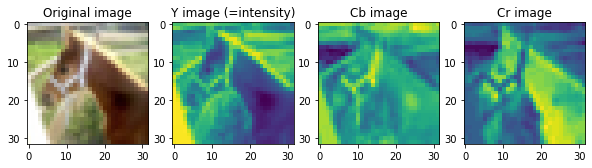

In [7]:
im_arr = x_test[1]
image = array_to_img(im_arr)
plt.figure(figsize=(10,5))
plt.subplot(1,4,1)
plt.title("Original image")
plt.imshow(image)
ycbcr = image.convert('YCbCr')
y, cb, cr = ycbcr.split()


y_arr = np.array(y)
cb_arr = np.array(cb)
cr_arr = np.array(cr)
c_arr = np.dstack((cb_arr,cr_arr))
plt.subplot(1,4,2)
plt.title("Y image (=intensity)")
plt.imshow(y)
plt.subplot(1,4,3)
plt.title("Cb image")
plt.imshow(cb)
plt.subplot(1,4,4)
plt.title("Cr image")
plt.imshow(cr)


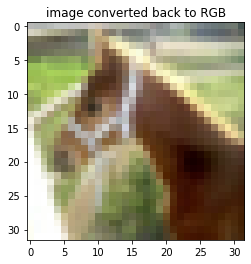

In [8]:
y_re = Image.fromarray(y_arr, mode ="L")
cb_arr= (c_arr.T[0][:][:]).T
cr_arr= (c_arr.T[1][:][:]).T
cb_re = Image.fromarray(cb_arr, mode ="L")
cr_re = Image.fromarray(cr_arr, mode ="L")

x= Image.merge('YCbCr', (y_re, cb_re, cr_re)).convert('RGB')

plt.title("image converted back to RGB")
plt.imshow(x)

In [11]:
def lum_chrom_convertion(data):
 chromas = []
 luminas = []
 for im_arr in data:
  ycbcr = array_to_img(im_arr).convert('YCbCr')
  y, cb, cr = ycbcr.split()
  luminas.append(np.array(y))
  chromas.append(np.dstack((np.array(cb),np.array(cr))))
 return [np.array(chromas).astype("float32")/255,np.array(luminas).astype("float32")/255]

def rgb_convertion(chrom,lum):
 chrom = (chrom*255).astype("uint8")
 lum = (lum*255).astype("uint8")         
 rgbs = []
 for i in range(len(lum)):
  y_re = Image.fromarray((lum[i].T[0][:][:]).T, mode ="L")
  c_arr = chrom[i]
  cb_re = Image.fromarray((c_arr.T[0][:][:]).T, mode ="L")
  cr_re = Image.fromarray((c_arr.T[1][:][:]).T, mode ="L")
  x= Image.merge('YCbCr', (y_re, cb_re, cr_re)).convert("RGB")
  rgbs.append(np.array(x))
 return rgbs

def gray_convertion(data):
    grays=[]
    for im_arr in data:
       gray = array_to_img(im_arr).convert('L')
       gray_arr = np.array(gray)
       grays.append((gray_arr))
    grays = np.array(grays).astype("float32")/255
    return tf.expand_dims(grays, axis=-1)


In [12]:
# converting the RGB images into YCbCr imges
[chrom_test,lum_test] = lum_chrom_convertion(x_test)
[chrom_train,lum_train] = lum_chrom_convertion(x_train)
[chrom_val,lum_val] = lum_chrom_convertion(x_val)

gray_test = gray_convertion(x_test)
gray_train = gray_convertion(x_train)
gray_val = gray_convertion(x_val)

## Training

Here below, several autoencoders are trained for a colorisation task. Different architecture are tried for increasing the performances

## A first Autoencoder, predicting RGB

Firstly, the same Autoencoder architecture as for the previous task is tried. The RGB representation is used.

Epoch 1/10
1500/1500 [==============================] - 69s 45ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 2/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 3/10
1500/1500 [==============================] - 82s 55ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 4/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 5/10
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 6/10
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoc

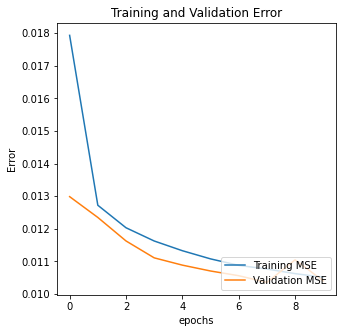

In [ ]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=3)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, x_val))
mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


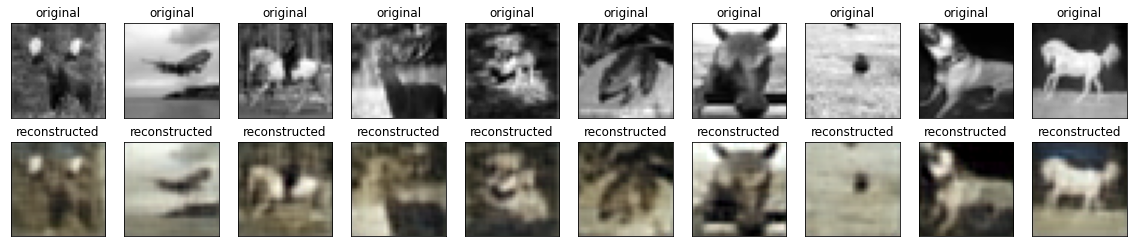

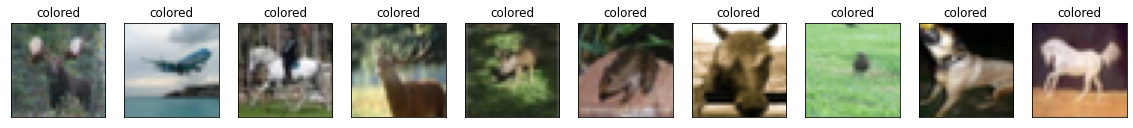

In [ ]:
plot_test(gray_ae,gray_test,gray = True,RGB = True,x_color = x_test)

There, we can observe that we get the same issues as the previous task, i.e. a lot of image details are lost during the reconstruction. We can observe that the has learned to colorise the images with a color palette of black-white-brown/green. Let's now see how the models perfoms when the YCbCr color representation is used.

## An autoencoder, predicting the chrominance

Epoch 1/10
1500/1500 [==============================] - 41s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 7/10

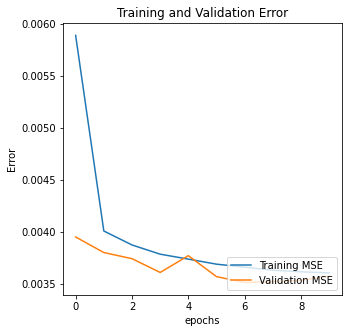

In [16]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Test Error : [0.005888887215405703, 0.004008390940725803, 0.0038739866577088833, 0.00378542416729033, 0.0037379830610007048, 0.0036893333308398724, 0.0036607703659683466, 0.003631145227700472, 0.0036162827163934708, 0.003605073085054755]
RGB convertion


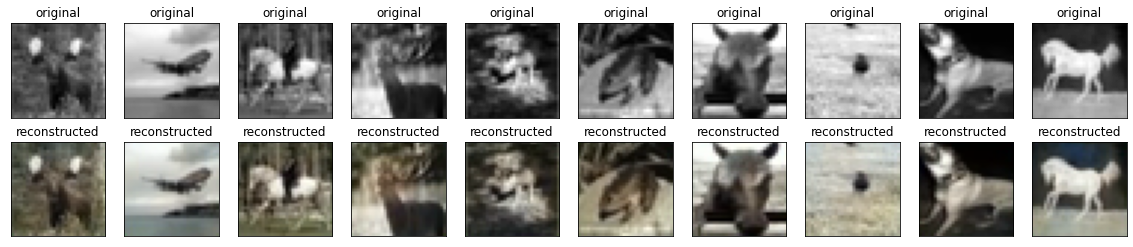

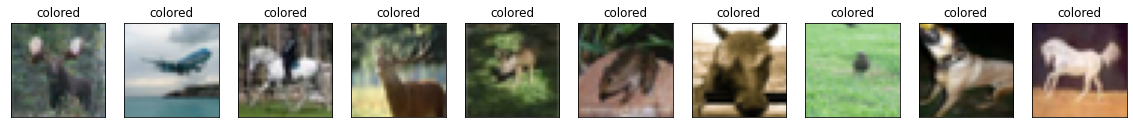

In [17]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

We can first of all observe that, compared the previous model, the error has been divided by 3. This can be explain that is task is a bit simpler since we only have to predict 2 dimentions (Cb and Cr, instead of R., B. andG.). We can see that the model has included the Blue color in its color palette for colorisation. Let's now try different architecture and hyperparameter variantions in order to improve this model.

## Larger strides

changing to model stride form 1 to 3, and removing the pooling layers

In [18]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 9s 5ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 6/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 7/10
1500/

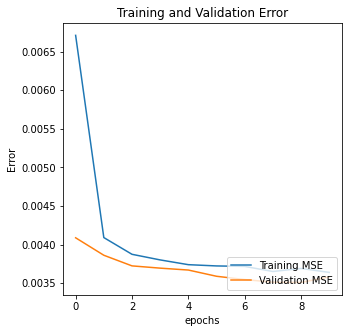

In [19]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides = 3)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 4ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Test Error : [0.006710794288665056, 0.004091999493539333, 0.0038752721156924963, 0.0038025344256311655, 0.003740963526070118, 0.0037246369756758213, 0.003718435298651457, 0.003652633400633931, 0.003692016936838627, 0.003640976035967469]
RGB convertion


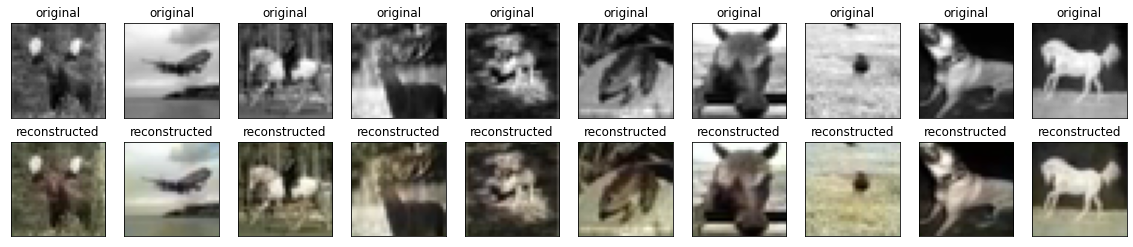

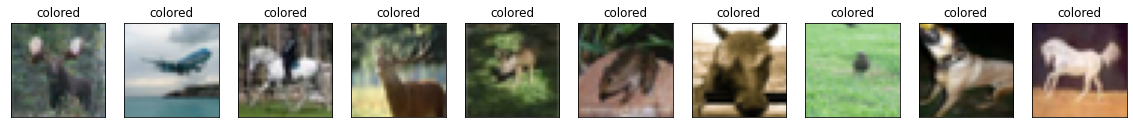

In [20]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)
plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

No significant improvement is observed, compared to the original model.

## Average Pooling

In [29]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.UpSampling2D(size = (2,2)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=1, padding='same', activation='relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 7/10

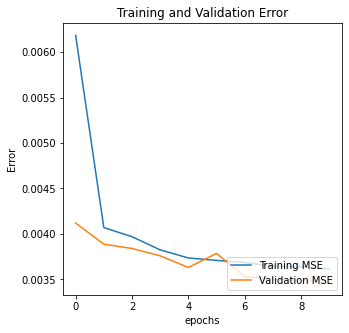

In [30]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.004008217249065638, 0.0037938235327601433, 0.0036781742237508297, 0.0036297417245805264, 0.003609789302572608, 0.003600608091801405, 0.0035704371985048056, 0.0035590026527643204, 0.003540699603036046, 0.0035291335079818964]
RGB convertion


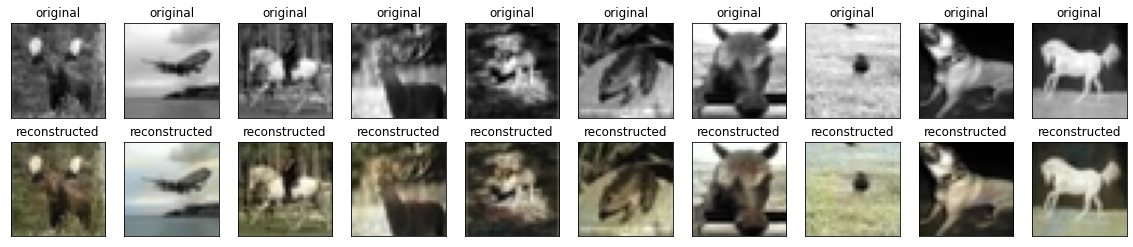

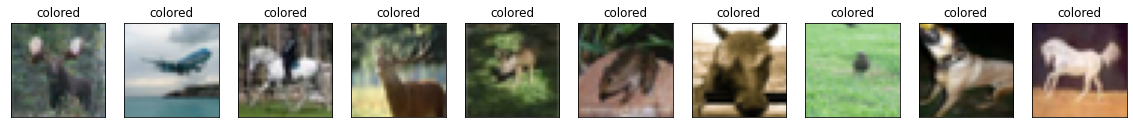

In [28]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)
plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

Here we have quite of an improvement compared the Max pooling. This can be explain by the fact that to describe the color of a region, we would rather looking at the average color rather than the maximum color of the region (if there is one spot high values, the entire region is marker as this value).

## Adding a dense sigmoid as last layer

adding a last color prediction layer might help the model to further improve its performances

In [31]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 7/10

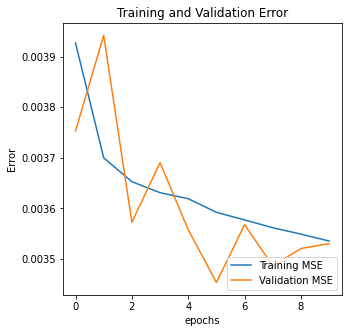

In [32]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides = 1)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.0039269644767045975, 0.0036997664719820023, 0.003652612678706646, 0.0036308984272181988, 0.003618956310674548, 0.0035920359659940004, 0.0035770093090832233, 0.0035616240929812193, 0.0035489399451762438, 0.0035353396087884903]
RGB convertion


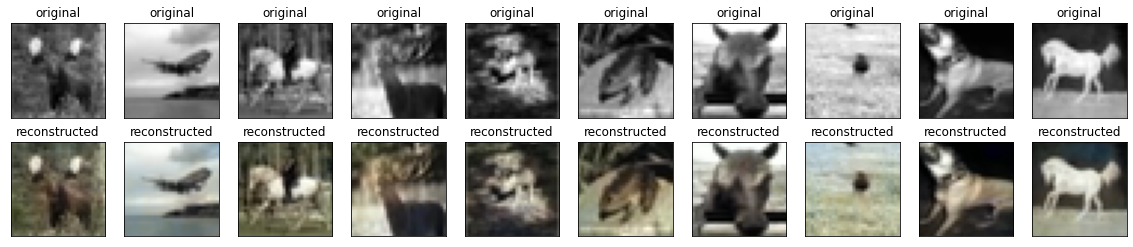

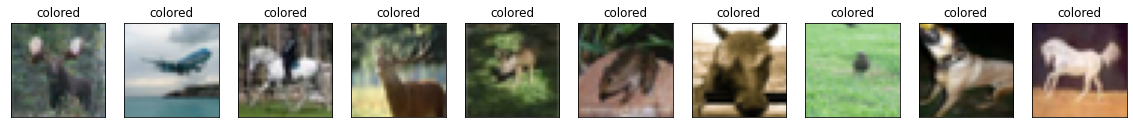

In [33]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)
plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

No significant performances improvement is observed, compared to the model using average pooling

## Adding a dense relu as last layer

In [34]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 7/10

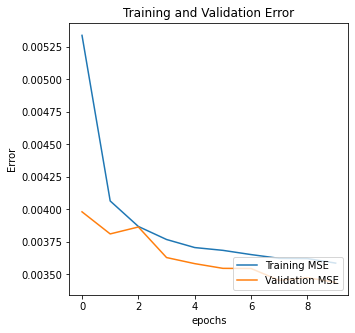

In [36]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides = 1)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.005574693903326988, 0.004122835583984852, 0.004049739334732294, 0.0038990878965705633, 0.00376988691277802, 0.0036891591735184193, 0.0036911398638039827, 0.0036446438170969486, 0.0036383834667503834, 0.0035979582462459803]
RGB convertion


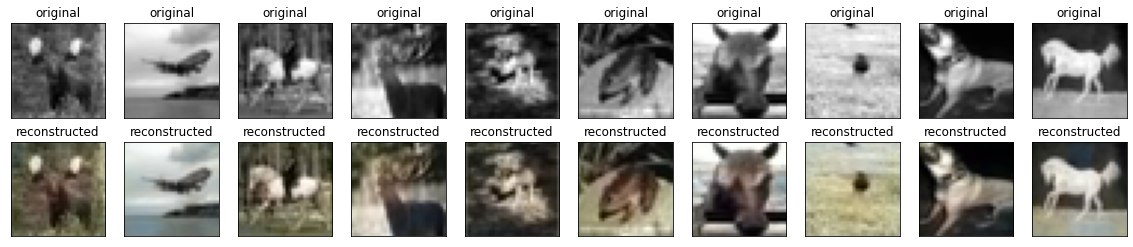

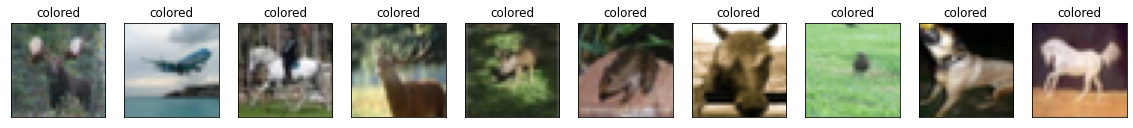

In [ ]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)
plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

No significant improvement is observed

## Larger kernel

In [45]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.UpSampling2D(size = (2,2)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=1, padding='same', activation='relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 7/10

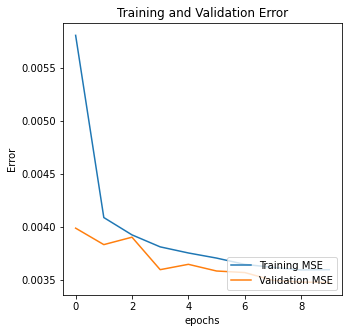

In [39]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, kernel_size = 5)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.005809422582387924, 0.0040862830355763435, 0.00392231997102499, 0.003808965440839529, 0.0037513170391321182, 0.003702909452840686, 0.003643442178145051, 0.0036149988882243633, 0.0035905013792216778, 0.003592860186472535]
RGB convertion


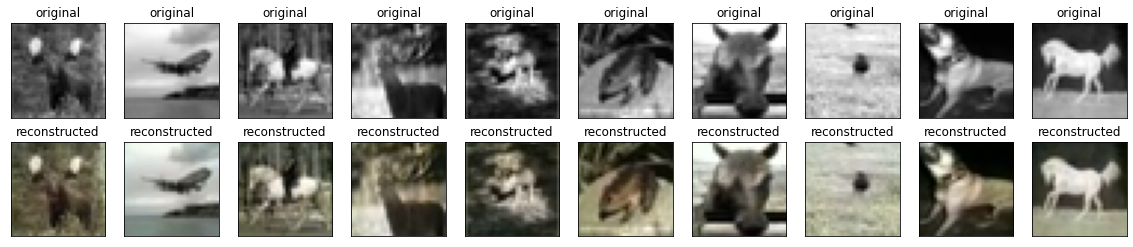

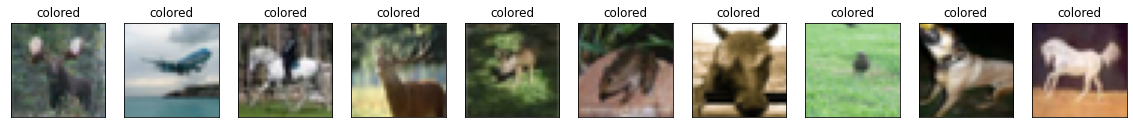

In [40]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

No significant improvement is observed

## Even larger kernel

Epoch 1/10
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 7/1

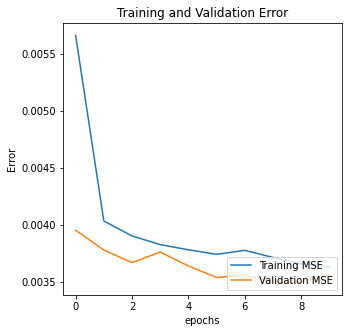

In [41]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, kernel_size = 7)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Test Error : [0.00566459447145462, 0.004032803699374199, 0.0039012006018310785, 0.0038247716147452593, 0.0037795789539813995, 0.0037389935459941626, 0.0037741241976618767, 0.00371209136210382, 0.003657170571386814, 0.0036264946684241295]
RGB convertion


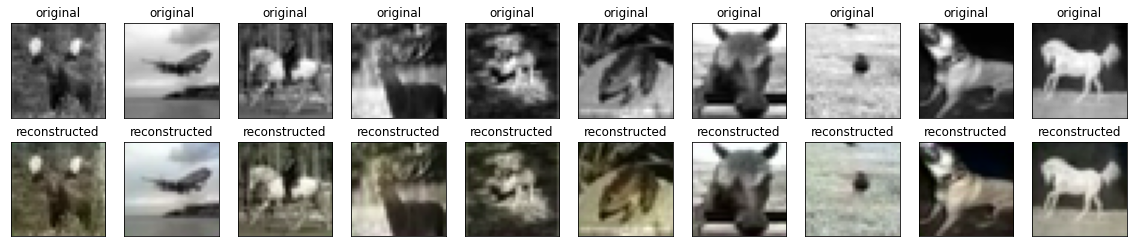

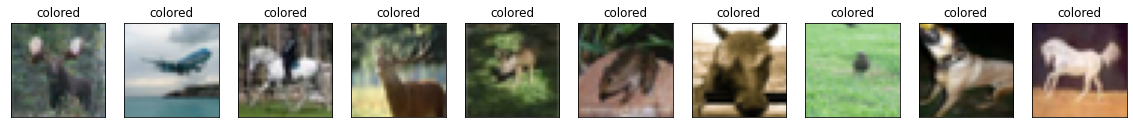

In [42]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

No significant improvement is observed, the performances are decreasing

## Smaller Kernel

Epoch 1/10
1500/1500 [==============================] - 12s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 7/10

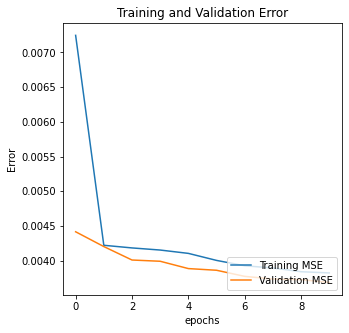

In [43]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, kernel_size = 2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 4ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Test Error : [0.007246399763971567, 0.004221445415169001, 0.0041834102012217045, 0.004152874927967787, 0.0041047739796340466, 0.004003574140369892, 0.003926228731870651, 0.003894224762916565, 0.0038405319210141897, 0.0038233953528106213]
RGB convertion


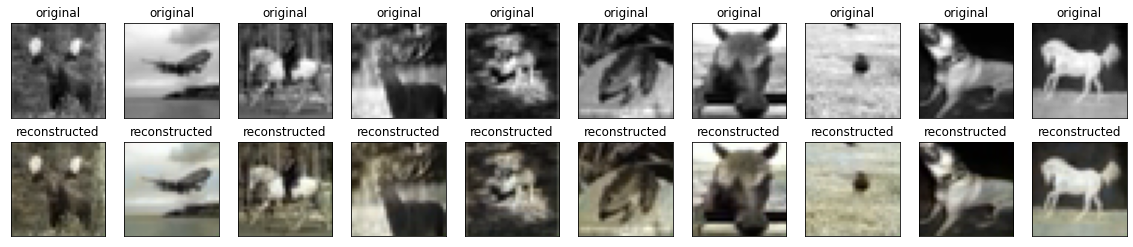

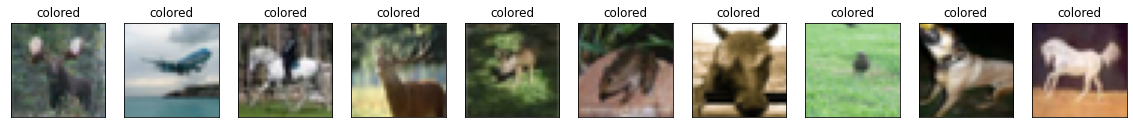

In [44]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

No significant improvement is observed, the performance are decreasing

## Larger channel number

Here, a model with a bigger number of channels for the convolutional layers is tried


In [50]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(16, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(24, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(24, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 2/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 6/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 7/10

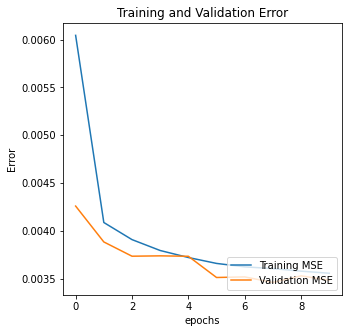

In [51]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides=1, kernel_size = 3)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.0060434164479374886, 0.004088560584932566, 0.0039098202250897884, 0.003795997006818652, 0.003722784575074911, 0.003661072114482522, 0.0036251957062631845, 0.003607046790421009, 0.0035801709163933992, 0.003558600787073374]
RGB convertion


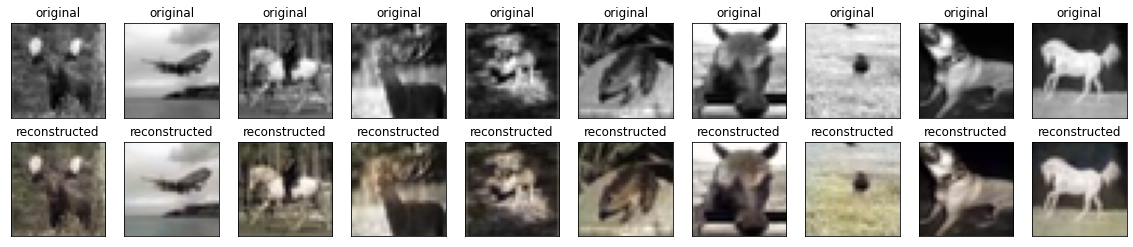

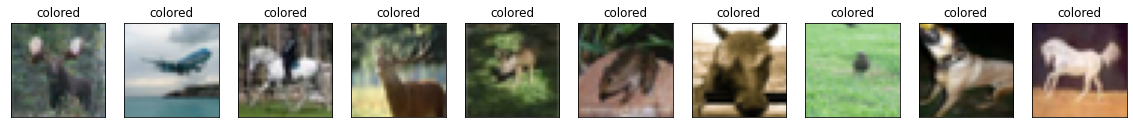

In [52]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

No significant improvement is observed

## Adding Data Augmentation

For this version of the model, data augmentation layers are added. The input images are randomly horizontally flipped, than randomly rotated to up to 0.2 angle (radian). This might make the model more robust in identiying specific objects (eg dogs) and colorise them adequately.

In [65]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
                                        
      layers.experimental.preprocessing.RandomFlip('horizontal'),
      layers.experimental.preprocessing.RandomRotation(0.2),

      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.UpSampling2D(size = (2,2)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=1, padding='same', activation='relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/20
1500/1500 [==============================] - 15s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 7/20

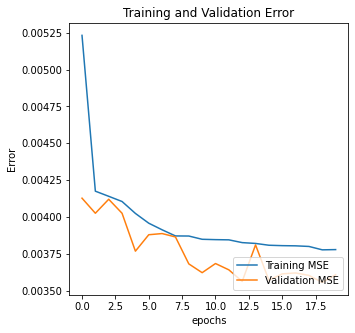

In [67]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=20,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Test Error : [0.005232691299170256, 0.004174636676907539, 0.00413986062631011, 0.004104484338313341, 0.0040235756896436214, 0.003957180771976709, 0.0039123836904764175, 0.003870686748996377, 0.0038700599689036608, 0.0038479522336274385, 0.0038455778267234564, 0.0038441584911197424, 0.003825344378128648, 0.0038197448011487722, 0.003807537956163287, 0.003804732346907258, 0.0038034787867218256, 0.0037992934230715036, 0.0037763086147606373, 0.0037779470440000296]
RGB convertion


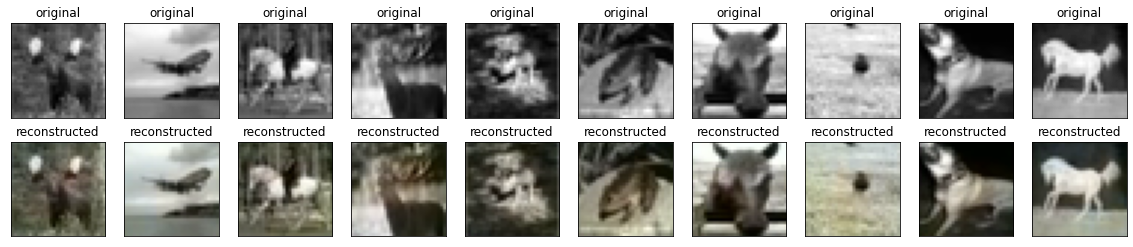

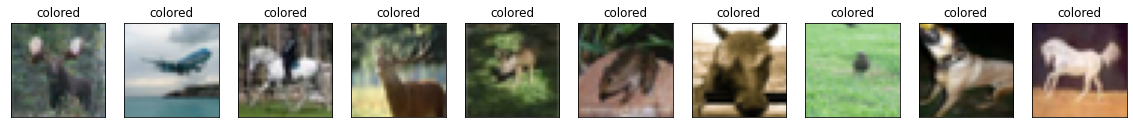

In [68]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

Data Augmentation has not helped the model to better undestand to how colorize grayscale images.

## Longer training for the best model found so far, with early stopping

Let's further train the best model found so far (only Average pooling led to increase in performances). The training lasts until no improvement is done on the validation set for more than 12 epochs.

In [72]:
early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=12,
      verbose=1, 
      mode = 'min',
      restore_best_weights=True
  )

class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
                  
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2,2)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.UpSampling2D(size = (2,2)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=1, padding='same', activation='relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/100
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 4/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/100
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoc

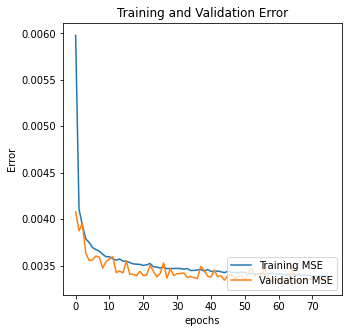

In [73]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=100,
                shuffle=True,
                callbacks = [early_stop],
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 4ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Test Error : [0.0059785395860672, 0.00410865293815732, 0.003935287240892649, 0.0037892607506364584, 0.0037495880387723446, 0.0036960493307560682, 0.003673722967505455, 0.0036566162016242743, 0.0036221968475729227, 0.0035969270393252373, 0.0035971805918961763, 0.0035751790273934603, 0.0035596529487520456, 0.0035715431440621614, 0.003549681045114994, 0.0035488258581608534, 0.0035334695130586624, 0.0035198102705180645, 0.0035160852130502462, 0.003514230716973543, 0.003502884181216359, 0.0035095191560685635, 0.0035235388204455376, 0.0034889548551291227, 0.003485143417492509, 0.003474605269730091, 0.003487692214548588, 0.003467920934781432, 0.0034701635595411062, 0.003469859715551138, 0.003470923751592636, 0.00346970371901989, 0.0034618263598531485, 0.0034699486568570137, 0.0034484611824154854, 0.0034493575803935528, 0.0034556875471025705, 0.003458376508206129, 0.0034422308672219515, 0.0034581

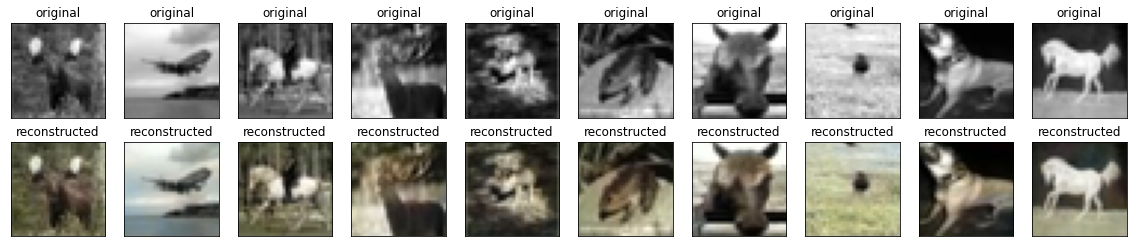

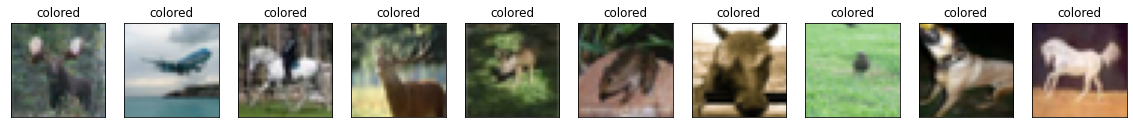

In [74]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

Here are the final results. The can observe that the model is most good at recoloring brown-grey-black-white and green colors. This may be because those are the most common colors. Hence, the model been able to understand this abundance. The model has become an expert in prediction brown colors and green colors.